# Richards equation

In this tutorial we present how to solve a Richards equation with [PyGeoN](https://github.com/compgeo-mox/pygeon).  The unkwons are the velocity $q$ and the pressure $p$.

Let $\Omega=(0,2)\times(0,3)$ with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Given 
$k$ the matrix permeability, we want to solve the following problem: find $({q}, \psi)$ such that
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(\psi) {q} + \nabla \psi = -\nabla z\\
\partial_t \theta (\psi) + \nabla \cdot {q} = 0
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
with boundary conditions:

$$
\psi(t,x,z)=
\left\{
\begin{array}{ll}
\begin{array}{l} 
-2+2.2 \frac{t}{\Delta t_D}, \text{ on } \Gamma_{D_1}, t\leq\Delta t_D\\
0.2, \text{ on } \Gamma_{D_1}, t>\Delta t_D\\
1-z, \text{ on } \Gamma_{D_2}
\end{array}
\end{array}
\right., \qquad \nu \cdot q = 0 \text{ on } \Gamma_N \qquad \psi(0,x,z) = 1-z \text{ on } \Omega$$
and
$$
\Gamma_{D_1} = \left\{ (x,z) \in \partial \Omega \:|\: x \in [0,1] \wedge z=3  \right\},\\
\Gamma_{D_2} = \left\{ (x,z) \in \partial \Omega \:|\: x = 2 \wedge z \in [0,1]  \right\},\\
\Gamma_{D} = \Gamma_{D_1} \cup \Gamma_{D_2},\\
\Gamma_{N} = \partial \Omega \setminus \Gamma_D
$$

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

### Import and parameters

In [1]:
import shutil
import os

import numpy as np
import scipy.sparse as sps
from scipy.sparse import linalg
import sympy as sp

import porepy as pp
import pygeon as pg

import time
from math import ceil, floor, log10, exp

import matplotlib.pyplot as plt

/opt/conda/lib/python3.11/site-packages/porepy/numerics/nonlinear/nonlinear_solvers.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


In [2]:
import sys
sys.path.insert(0, "/workspaces/richards/")

from richards.model_params import Model_Data
from richards.matrix_computer import Matrix_Computer

from richards.solver import Solver
from richards.solver_params import Solver_Data, Solver_Enum

In [3]:
# Set the maximum number of iterations of the non-linear solver
K = 50

# L-scheme parameter
L = 3.501e-2

# Set the mesh refinment
N = 20

# Set the number of steps (excluding the initial condition)
num_steps = 9

# Simulation time length
T = num_steps/48

# Time switch conditions (for the boundary condition)
dt_D = 1/16

# Fluid density
rho = 1000

# Relative and absolute tolerances for the non-linear solver
abs_tol = 1e-5
rel_tol = 1e-5

# Domain tolerance
domain_tolerance = 1 / (10 * N)

# Output directory
output_directory = 'single_stage_primal'

In [4]:
# Van Genuchten model parameters ( relative permeability model )
theta_s = 0.396
theta_r = 0.131

alpha = 0.423

n = 2.06
K_s = 4.96e-2

m = 1 - 1/n

In [5]:
# Time step
dt   = (T-0)/num_steps

In [6]:
model_data = Model_Data(theta_r=theta_r, theta_s=theta_s, alpha=alpha, n=n, K_s=K_s, T=T, num_steps=num_steps)

### $\theta$ and $k$, with their derivatives w.r.t. $\psi$

In [7]:
def quick_plot():
    psi_val = np.linspace(-2, 1, 100)

    theta_max = theta_s
    theta_min = theta_r

    _, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))

    ax1.plot(psi_val, model_data.theta(psi_val))
    ax1.plot(psi_val, theta_max * np.ones_like(psi_val), linestyle="--", color="red")
    ax1.plot(
        psi_val,
        theta_min * np.ones_like(psi_val),
        linestyle="--",
        color="green",
    )
    ax1.set_title("theta")

    ax2.plot(psi_val, model_data.hydraulic_conductivity_coefficient(psi_val))
    ax2.set_title("K")

    ax3.plot(psi_val, model_data.inverse_hydraulic_conductivity_coefficient(psi_val))
    ax3.set_title("K^-1")

    ax4.plot(psi_val, model_data.theta(psi_val, 1))
    ax4.set_title("d theta / d psi")

    ax5.plot(psi_val, model_data.hydraulic_conductivity_coefficient(psi_val, 1))
    ax5.set_title("d (K) / d psi")

    ax6.plot(psi_val, model_data.inverse_hydraulic_conductivity_coefficient(psi_val, 1))
    ax6.set_title("d (K^-1) / d psi")


    plt.show()

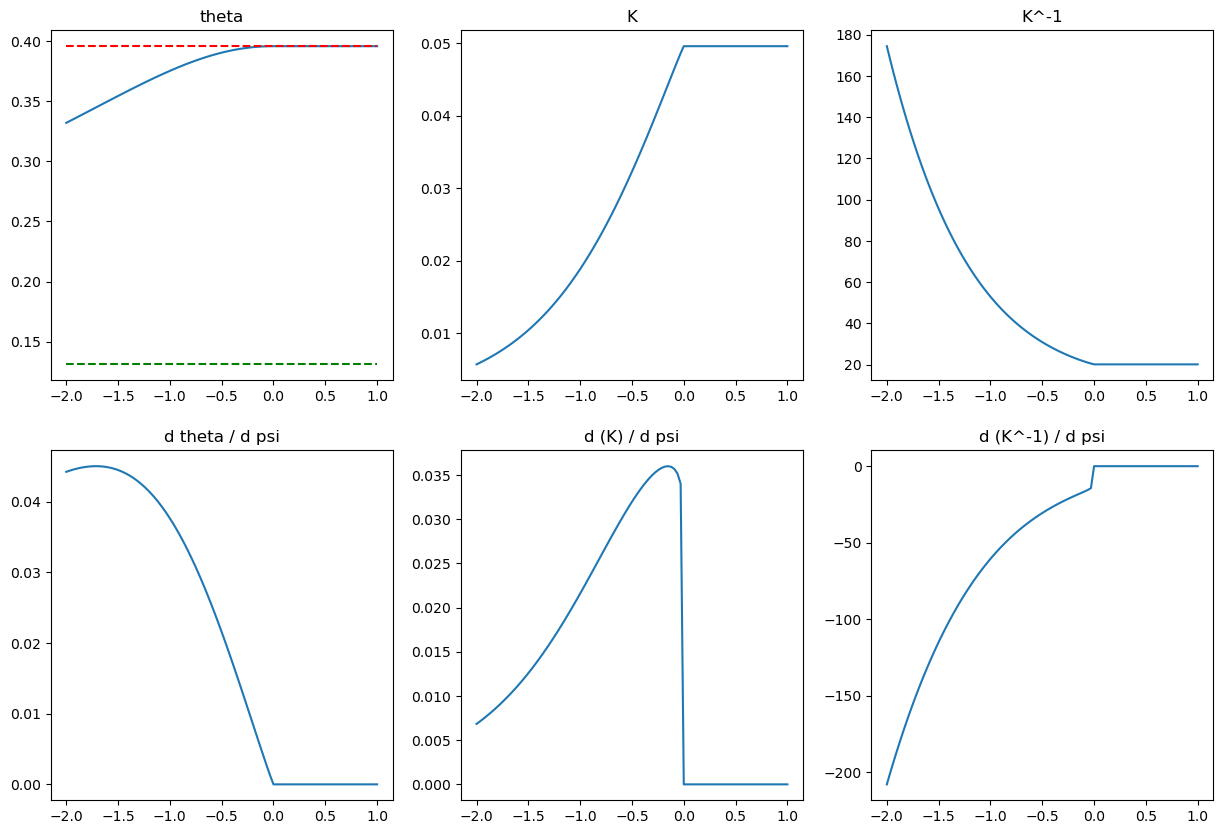

In [8]:
quick_plot()

### Domain preparation

In [9]:
# Prepare the domain and its mesh
subdomain = pp.StructuredTriangleGrid([2*N, 3*N], [2,3])
pg.convert_from_pp(subdomain)

# Convert it to a mixed-dimensional grid
mdg = pg.as_mdg(subdomain)

In [10]:
key = "flow"

# Collection of boundary conditions
bc_value = []
bc_essential = []

# Initial pressure
initial_pressure = []

In [11]:
# Initial pressure function
def initial_pressure_func(x): 
    return 1

In [12]:
# Fake loop to extract the grid and its data (i.e. conductivity tensor)
subdomain, data = mdg.subdomains(return_data=True)[0]

# Gamma_D1 and Gamma_D2 boundary faces
gamma_d1 = np.logical_and(subdomain.nodes[0, :] > 0-domain_tolerance, np.logical_and(subdomain.nodes[0, :] < 1+domain_tolerance, subdomain.nodes[1, :] > 3-domain_tolerance))
gamma_d2 = np.logical_and(subdomain.nodes[0, :] > 2-domain_tolerance, np.logical_and(subdomain.nodes[1, :] > 0-domain_tolerance, subdomain.nodes[1, :] < 1+domain_tolerance))

gamma_d  = np.logical_or(gamma_d1, gamma_d2)
bc_essential = gamma_d

# Add a lambda function that generates for each time instant the (discretized) natural boundary conditions for the problem
bc_value = lambda t: np.array(gamma_d2, dtype=float) + np.array(gamma_d1, dtype=float) * min(3.2, 1 + 2.2 * t / dt_D)

### Method

A quick recap:
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(\psi) {q} + \nabla \psi = -\nabla z\\
\partial_t \theta (\psi) + \nabla \cdot {q} = 0
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
becames, with the time discretization:

$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(\psi^{n+1}_k) {q^{n+1}_{k+1}} + \nabla \psi^{n+1}_{k+1} = -\nabla z\\
\frac{\partial \theta(\psi_k^{n+1})}{\partial \psi} \frac{\psi_{k+1}^{n+1}}{\Delta t} + \nabla \cdot {q^{n+1}} = \frac{\partial \theta(\psi_k^{n+1})}{\partial \psi} \frac{\psi_{k}^{n+1}}{\Delta t} + \frac{\theta (\psi^{n}) - \theta (\psi^{n+1}_k)}{\Delta t} 
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$

In [13]:
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

In [14]:
# assemble initial solution
cp = Matrix_Computer(mdg)

In [15]:
solver_data = Solver_Data(mdg=mdg, initial_solution=cp.P1.interpolate(subdomain, initial_pressure_func), 
                          scheme=Solver_Enum.NEWTON, 
                          bc_essential=lambda t: bc_essential, bc_essential_value=bc_value,
                          eps_psi_rel=rel_tol, eps_psi_abs=abs_tol,
                          max_iterations_per_step=K, L_Scheme_value=L,
                          output_directory=output_directory, report_name='primal',
                          primal=True, integration_order=3, prepare_plots=True, 
                          shape_x=2*N+1, shape_y=3*N+1)

In [16]:
solver = Solver(model_data=model_data, solver_data=solver_data)

Csv_Exporter: A file with name primal_NEWTON_richards_solver.csv is detected. I'll delete it
Time 0.02083
Iteration #001, error L2 relative psi:    0.125857299
Iteration #002, error L2 relative psi:    0.027196355
Iteration #003, error L2 relative psi:    0.003554351
Iteration #004, error L2 relative psi:    0.000288331
Iteration #005, error L2 relative psi:    0.000013818

Time 0.04167
Iteration #001, error L2 relative psi:    0.183394699
Iteration #002, error L2 relative psi:    0.064771051
Iteration #003, error L2 relative psi:    0.016163453
Iteration #004, error L2 relative psi:    0.002465635
Iteration #005, error L2 relative psi:    0.000372881
Iteration #006, error L2 relative psi:    0.000085020
Iteration #007, error L2 relative psi:    0.000011969

Time 0.0625
Iteration #001, error L2 relative psi:    0.264432198
Iteration #002, error L2 relative psi:    0.110499572
Iteration #003, error L2 relative psi:    0.033976861
Iteration #004, error L2 relative psi:    0.007461752
Ite

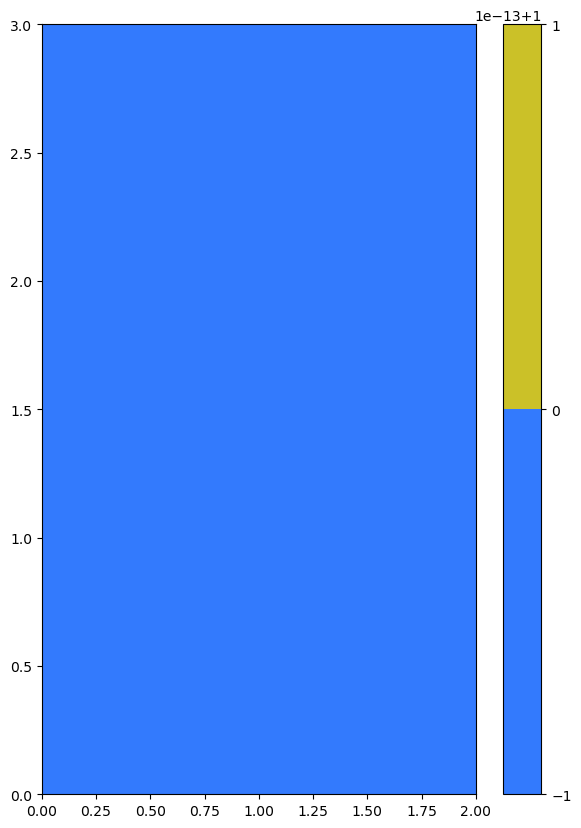

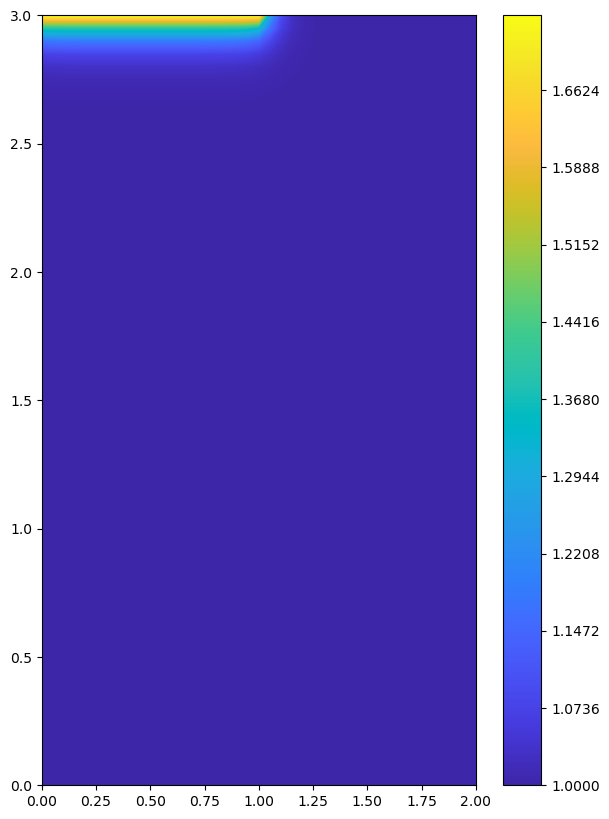

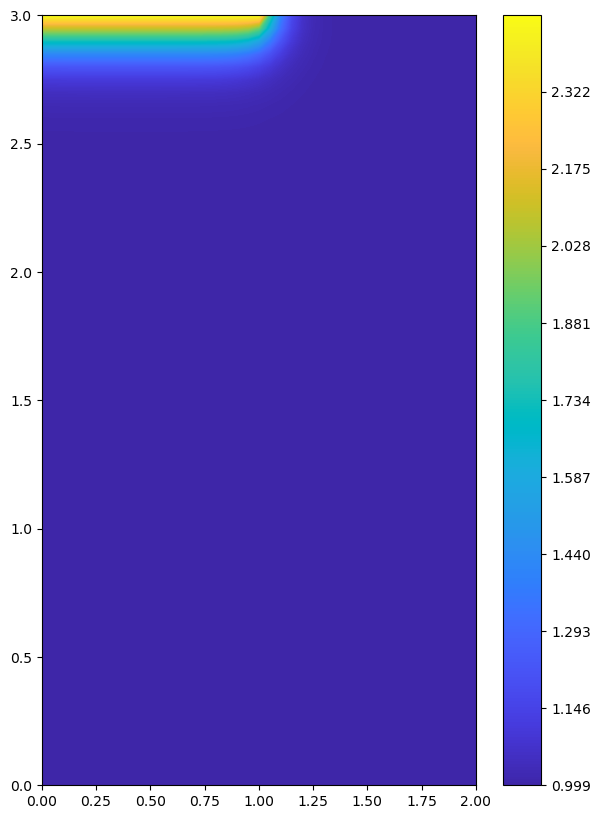

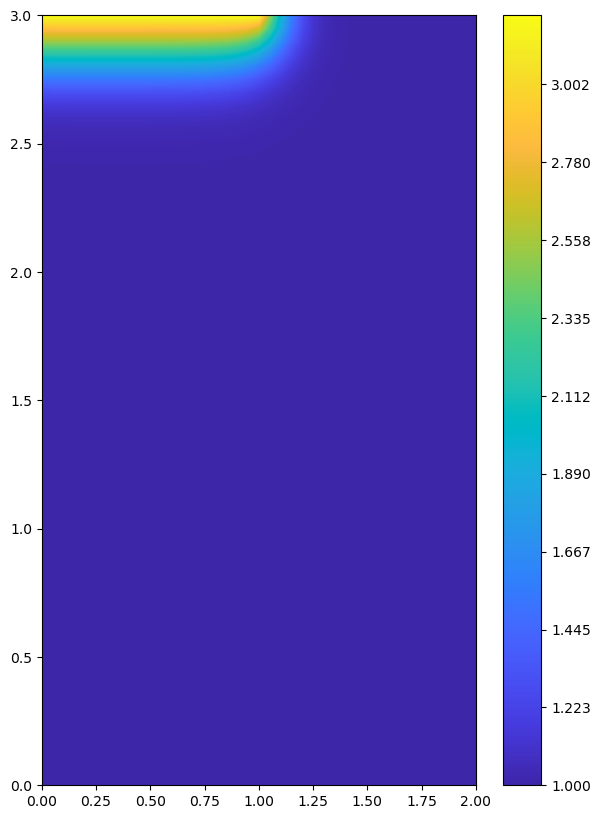

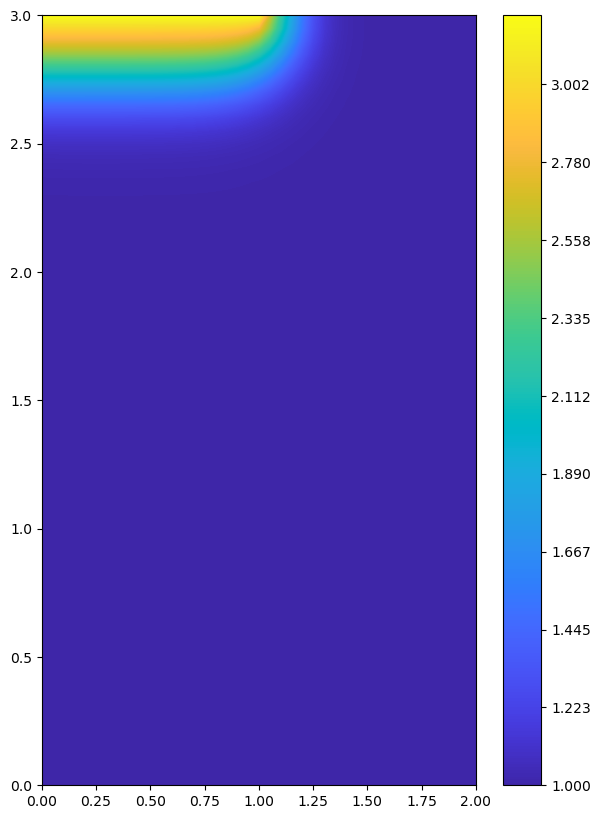

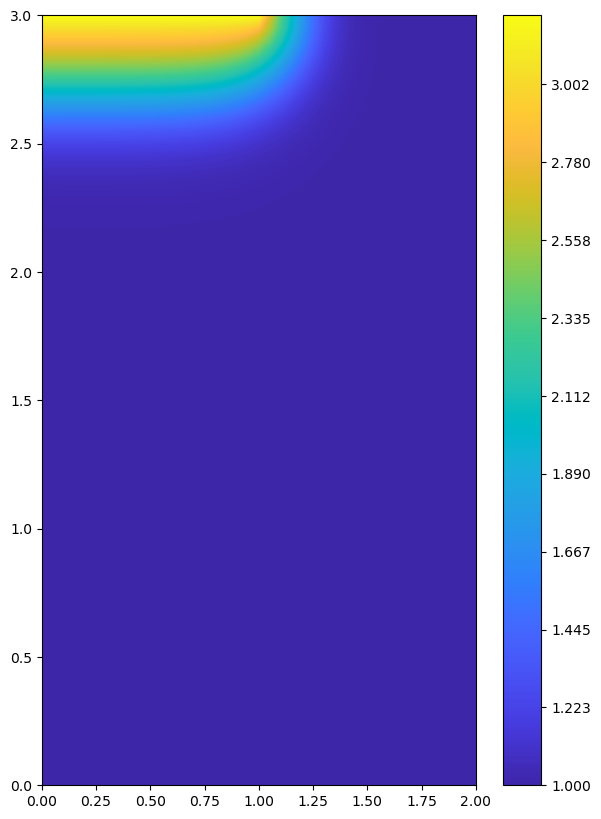

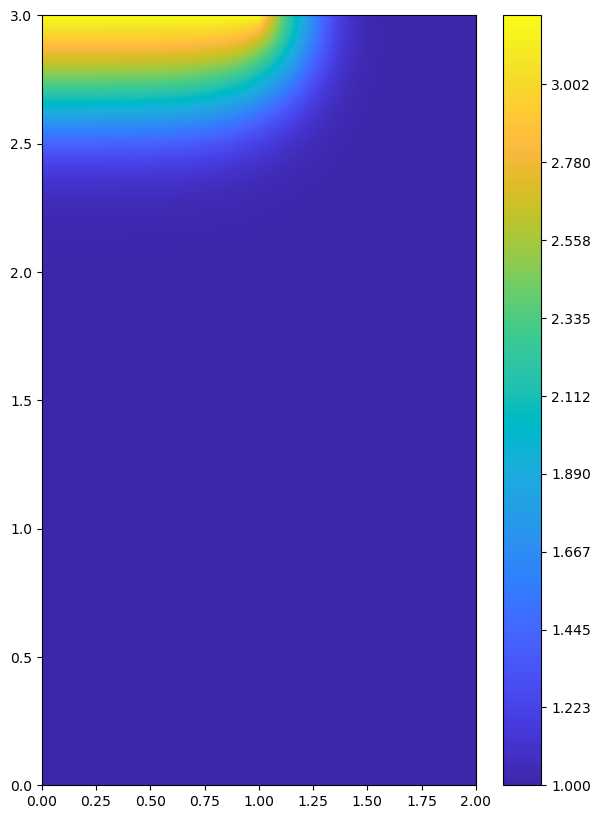

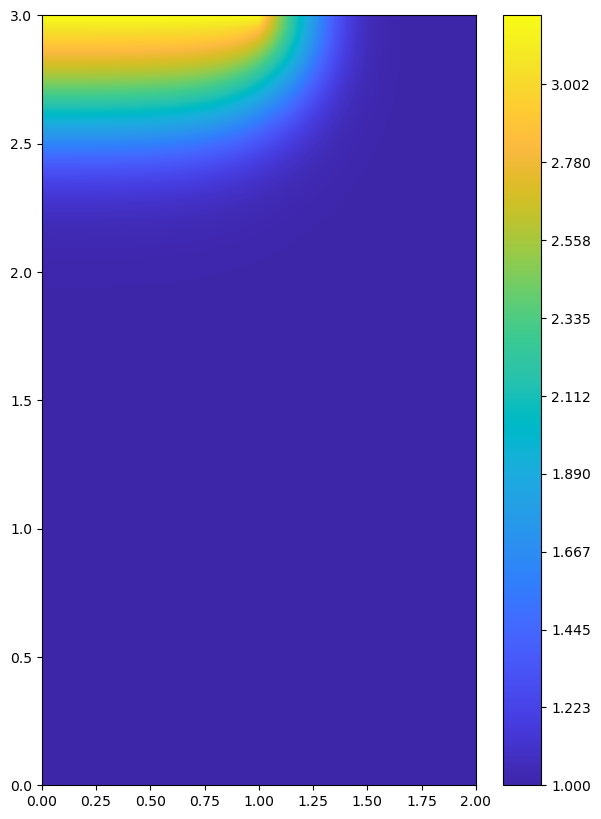

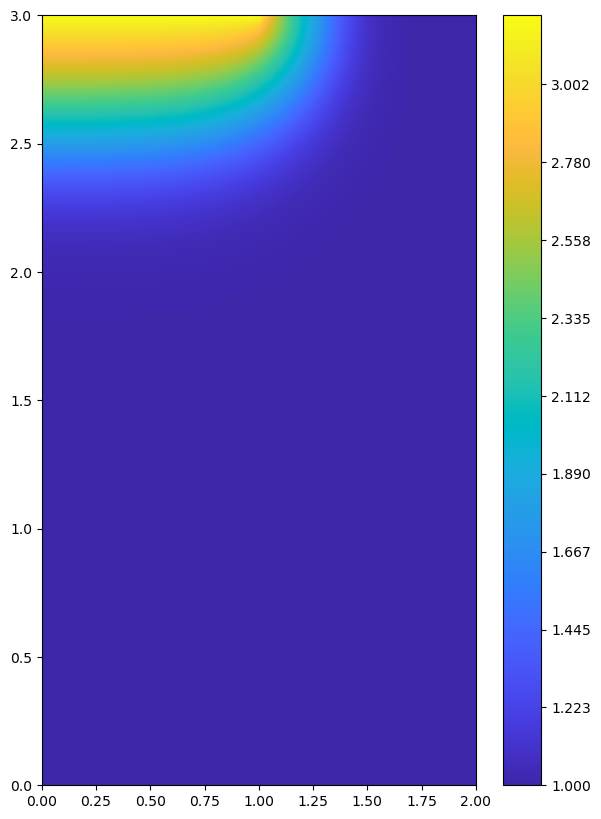

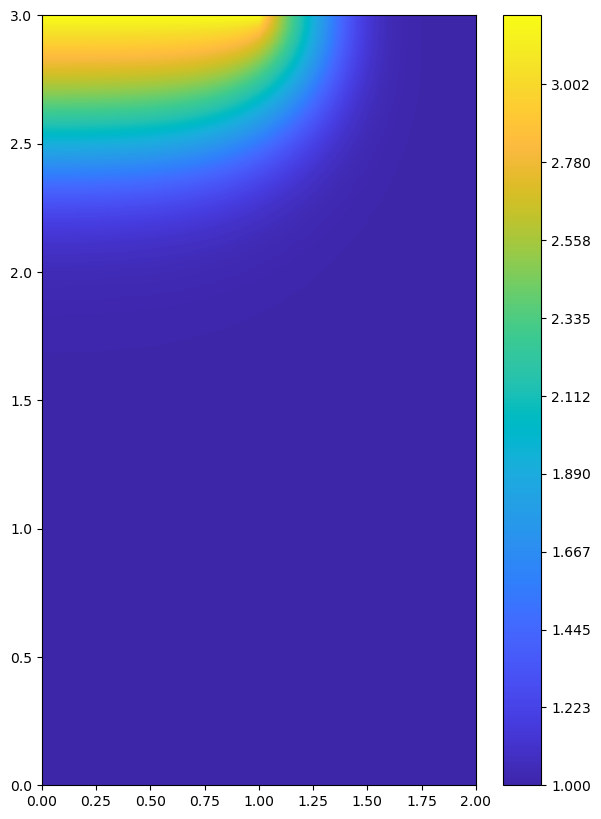

In [17]:
start = time.time()
solver.solve()
end = time.time()

print('')
print(end - start)